<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Diss Mere
This notebook has been based off the example of Crystal Correlations - included in the PyleoClim Paper.

In this notebook, we investigate the decadally average record of varve width from Diss Mere. We then compare it to the AMOC in the TraCE simulation. 


## Table of Contents
* [Data Exploration](#dataexp)
* [Persistence](#persistence)
    - [Null models](#nulls)
* [Detrending](#detrend)

## <a name='dataexp'>Data Exploration</a>
 We start by loading a few useful packages:

In [2]:
import matplotlib.pyplot as plt    
import pyleoclim as pyleo
pyleo.set_style('web')  # set the visual style
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

First we load in the varve record:

Index(['Age BP', 'Varve'], dtype='object')


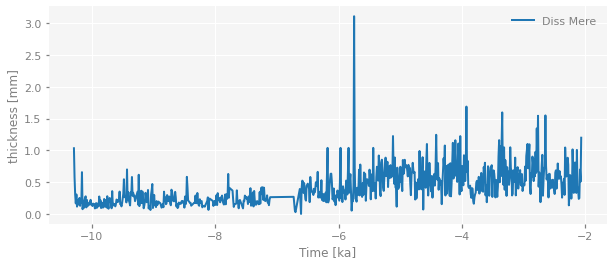

In [3]:
d = pd.read_csv('10_year_varve_thickness.csv')
print(d.columns)
dm = pyleo.Series(time=-d['Age BP']/1000., value=d['Varve'],
                      time_name='Time', time_unit='ka',label='Diss Mere',
                      value_name='thickness', value_unit='mm')
fig, ax = dm.plot()   

Then let's load in the AMOC record from the TraCE simulation

Index(['time (ka BP)', 'maximum AMOC at 52N below 500m (Sv)'], dtype='object')


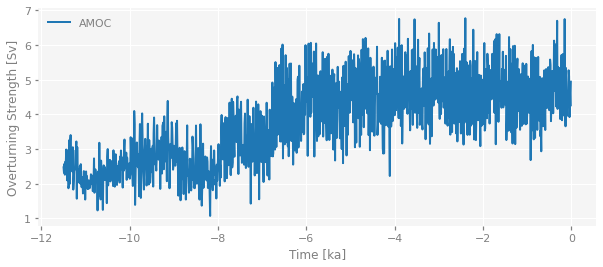

In [4]:
t = pd.read_csv('AMOC_52N_11.5-0kaBP.csv')
print(t.columns)
amoc = pyleo.Series(time=t['time (ka BP)'], value=t['maximum AMOC at 52N below 500m (Sv)'],
                      time_name='Time', time_unit='ka',label='AMOC',
                      value_name='Overturning Strength', value_unit='Sv')
fig, ax = amoc.plot()   

Now we can compute correlations between the two records. 

In [5]:
corr_res = amoc.correlation(dm, seed = 2333)
print(corr_res.r)

0.538585938420973


The correlation is $r=0.539$, and the natural question is: "Is this number significant (i.e. unusual)?" The standard way to assess this is with $t$-test using the test statistic: $$T = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}$$ (see e.g. Wilks, 2011)  If we plug in the values of $r$ and $n$, we get:  

In [6]:
n = len(dm.time)
nu = n-2
r = corr_res.r
T  = r *np.sqrt(nu)/(np.sqrt(1-r**2))
print("The test statistic is "+ str(T))

The test statistic is 17.423809941462743


Under standard assumptions (the data are independent and identically distributed), $T$ follows Student's $t$ distribution. If we make the same assumption and use the $t$ distribution from SciPy, we can readily compute the p-value (i.e. the probability to observe a test statistic at least as large as this one, under the null distribution):

In [7]:
from scipy.stats import t
pval = 1-t.cdf(T,nu)
print("The p-value is {:10.2e}".format(pval)) # express in exponential notation

The p-value is   0.00e+00


In other words, using the classic test for the significance of correlations "out of the box", one would conclude that the Diss Mere records is unambiguously related to the simualted AMOC. In other words, it looks _rather_ significant. 

However, this test (which is the one that most computing packages, including Excel, implement by default) is not appropriate here, as the theory only applies to data that are independent and indentically distributed ("IID"). Independence means that consecutive observations have no predictive power over each other, which is true neither of the Crystal Cave nor the instrumental target. That is to say: because temperature in one year tends to resemble temperature in the previous or following year (same for $\delta^{18}O$), the data are anything but independent. We will quantify this dependence, and its consequences, below. 

The full result of the Pyleoclim `correlation()` command looks like this:

In [8]:
print(corr_res)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-2     True



That is, the correlation value ships with an estimate of the p-value and a boolean flag (True/False) stating whether or not it is below the test level $\alpha$. However, the p-value here is estimated to be 13% (`'p': 0.13`), and therefore the correlation is not deemed significant (`'signif': False`) at the 5% level (`'alpha': 0.05`). How did `pyleoclim` arrive at such a different conclusion than the $2.4 \times 10^{-4}$ seen just above? 

### <a name='nulls'> Null Models</a>

There are in fact 3 ways to make this determination in Pyleoclim. While the standard null model for correlations in the statistical literature is the IID model, we have just seen that it is violated by the persistence of many timeseries, particularly the ones shown above.  The package does implements the classical T-test, but it is adjusted for the loss of degrees of freedom due to persistence as per Dawdy & Matalas (1964):

In [9]:
corr_ttest = amoc.correlation(dm,settings={'method':'ttest'})
print(corr_ttest)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-55    True



As a result, the the p-value for the test is now 15%, far above the  $2.4 \times 10^{-4}$ it would be under the IID assumption. 

The next option compares the observed correlation to the distribution of correlations with (by default) 1000 randomly-generated autoregressive (AR(1)) timeseries with the same persistence parameters as the original series, as measured by the lag-1 autocorrelation. This model is parametric, and is named _isopersistent_ because it preserves the persistence properties of each series:

In [10]:
corr_isopersist = amoc.correlation(dm,settings={'method':'isopersistent'}, seed = 2333)
print(corr_isopersist)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-6     True



Because this is a simulation-based method, the result will depent on the number of simulations, `nsim`.  Upping `nsim` ensures more consistent results, though in this case the result does not change: 

In [11]:
corr_isopersist = amoc.correlation(dm,settings={'method':'isopersistent','nsim':2000}, seed = 2333)
print(corr_isopersist)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-6     True



We see that the p-value changes subtly between these two cases, but not enough to change the result (the correlation is non significant either way). However, to ensure that these sampling issues won't affect the reproducibility of the results, we specify a [random seed](https://en.wikipedia.org/wiki/Random_seed). Note that the difference between “significant” and “not significant” p-values is not itself statistically significant (Gelman & Stern, 2006). 


The last null model method is `isospectral`, which phase-randomizes the original signals, thereby preserving the spectrum of each series but scrambling phase relations between the signals. This (non-paramettric) method was first proposed by Ebisuzaki (1997), and is called _isospectral_ because it leaves the spectrum (and therefore the autocorrelation function) intact. Since, this is also a simulation method, one can also play with the number of simulations, as done here:

In [12]:
corr_isospec = amoc.correlation(dm,settings={'method':'isospectral','nsim':2000}, seed = 4343)
print(corr_isospec)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-2     True



We see that this resulted is a modestly different p-value, but again one above 5%, which leads to rejection of the test. 

In this case, the three methods concur that the correlation is insignificant, though we encourage users to play with these methods in case they obtain results close to the test-level, to discourage p-hacking temptations. 


As mentioned earlier, the SST and Crystal Cave series are on different time axes, and `Pyleoclim` automated the process of aligning them, doing so under the hood so users can focus on doing science. However, it is useful to understand what is happening and how it can be customized, in case this makes a different to the analysis.  Like other `Pyleoclim` methods designed to compare timeseries,  `correlation()` relies on the `MultipleSeries.common_time()` method for alignment. The method implements three strategies for timeseries alignment:
1. interpolation
1. binning
1. Gaussian kernel smoothing

To explore it, let us first create a `MultipleSeries` object gathering those two series:

(<Figure size 432x288 with 3 Axes>,
 {0: <Axes:ylabel='Overturning Strength [Sv]'>,
  1: <Axes:ylabel='thickness [mm]'>,
  2: <Axes:xlabel='Time [ka]'>})

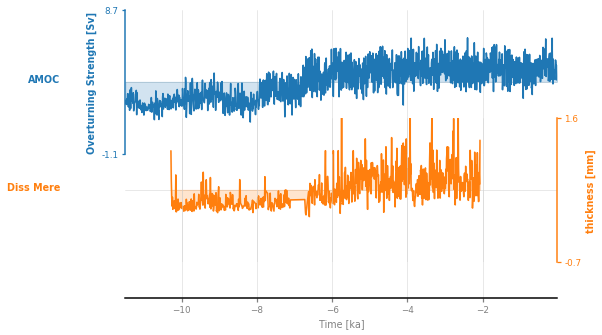

In [13]:
ms = pyleo.MultipleSeries([amoc,dm])
ms.stackplot()

By default, `common_time()` will implement linear interpolation. 

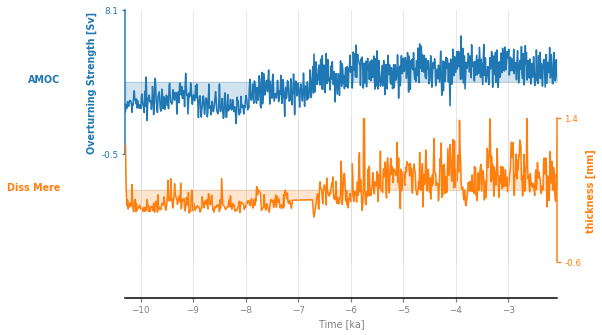

In [14]:
msi = ms.common_time()
fig, ax = msi.stackplot()

To see how the interpolation changed the original series, we can superimpose the original series as dots on top of this stackplot:

<Axes:ylabel='thickness [mm]'>

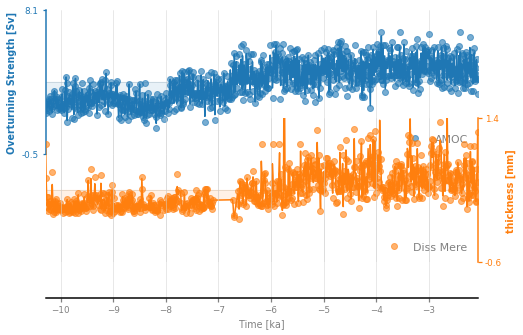

In [16]:
fig, ax = msi.stackplot(labels=None, fill_between_alpha=0.1)
amoc.plot(ax=ax[0],marker='o',linestyle='',xlabel='',alpha=0.6)
dm.plot(ax=ax[1],marker='o',linestyle='',color='C1',xlabel='', alpha=0.6)

### <a name='detrend'> Detrending</a>

Lets look at the imapct of detrending the datasets on the correlations.

First of all lets try conventional detrending:

(<Figure size 432x288 with 3 Axes>,
 {0: <Axes:ylabel='Overturning Strength [Sv]'>,
  1: <Axes:ylabel='thickness [mm]'>,
  2: <Axes:xlabel='Time [ka]'>})

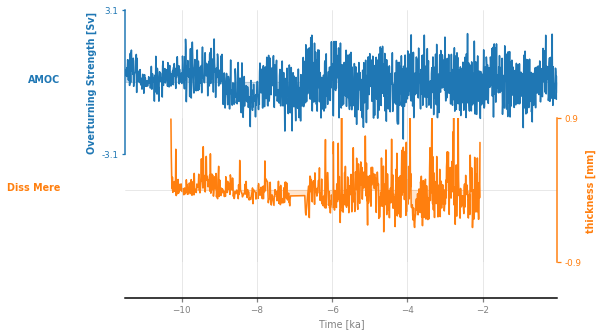

In [17]:
dm_emd = dm.detrend(method='emd')
amoc_emd = amoc.detrend(method='emd')
ms_emd = pyleo.MultipleSeries([amoc_emd,dm_emd])
ms_emd.stackplot()

In [18]:
corr_emd = amoc_emd.correlation(dm_emd, seed = 2333)
print(corr_emd)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0498391       0.32  False



So it isn't correlated once detrended - i.e. the forced signal is causing the correlation.

And now lets do something with filtering, to test the the opposite - i.e. that the low frequency trends contain the correlation...

We will use a low-pass (Lanczos) filter with a cut-off scale of 1. This equates to 1ka, as that's the units of the two time series.

<AxesSubplot:xlabel='Time [ka]', ylabel='Overturning Strength [Sv]'>

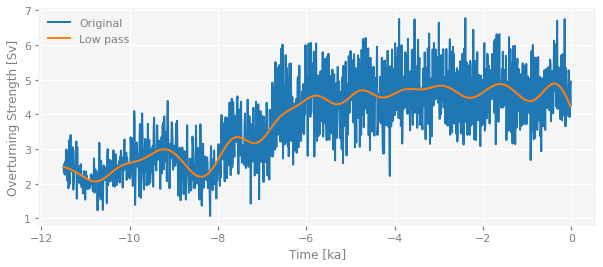

In [26]:
amoc_low = amoc.interp().filter(method='lanczos',cutoff_scale=1)
fig, ax = amoc.plot(label='Original')
amoc_low.plot(label='Low pass',ax=ax)

<AxesSubplot:xlabel='Time [ka]', ylabel='thickness [mm]'>

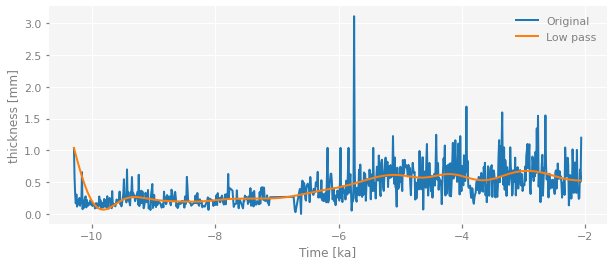

In [ ]:
dm_low = dm.interp().filter(method='lanczos',cutoff_scale=1)
fig, ax = dm.plot(label='Original')
dm_low.plot(label='Low pass',ax=ax)

I actually worry about the treatment at the very beginning of this record. It shows a strong uptick, which I don't think should be there - and is rather an end effect. So we'll only preform the correlation over a subsection of the record.

In [28]:
corr_low = amoc_low.slice([-10,-2]).correlation(dm_low, seed = 2333)
print(corr_low)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.930763  < 1e-6     True



So in conclusion, these records are only correlated because of the low frequency (i.e. forced) aspects of the reconstructions.

## Wavelets
Finally lets plots some wavelets of the two timeseries...

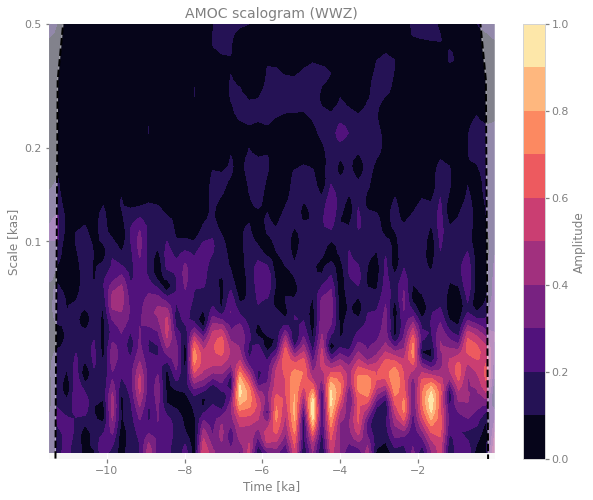

In [71]:
fig, ax = amoc.standardize().wavelet(method='wwz').plot(ylim=[0.02,0.5])

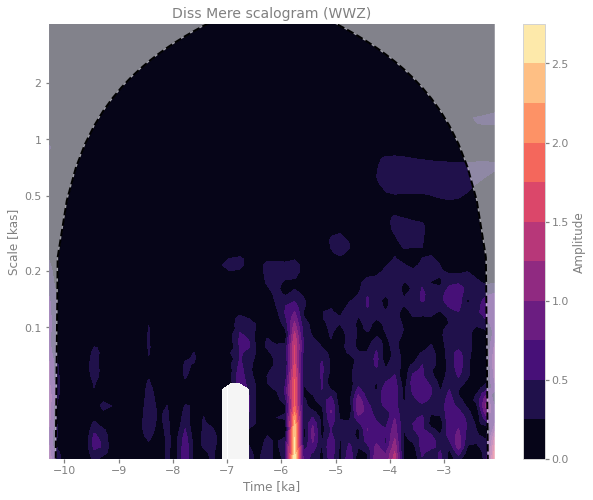

In [31]:
fig, ax = dm.wavelet(method='wwz').plot()

Well, I'm not going to lie the sinlge band above 3mm really has an outsize effect on the wavelets. Let's try it without this data - we'll remove using the outlier functionality in `Pyleoclim`

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time [ka]', ylabel='thickness [mm]'>)

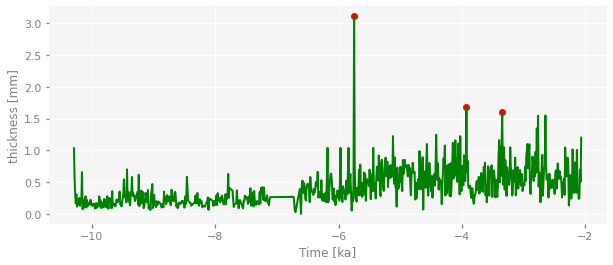

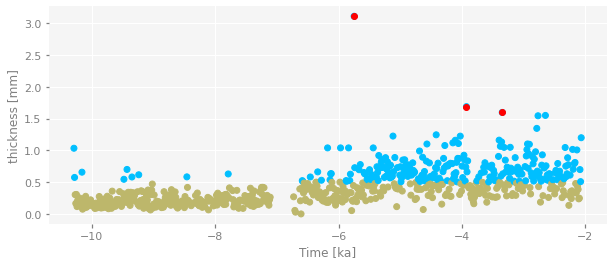

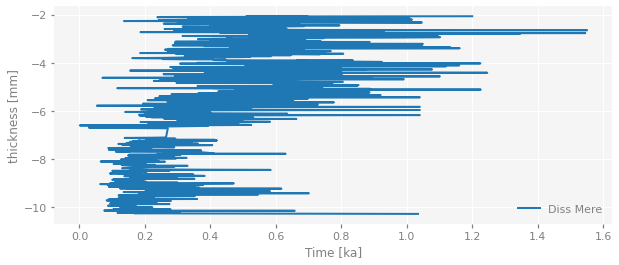

In [59]:
dm_homogen,res = dm.outliers(remove=True)
dm_homogen.plot()

That seems to have flipped the axes for for a reason that baffles me. Let's fix it.

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time [ka]', ylabel='thickness [mm]'>)

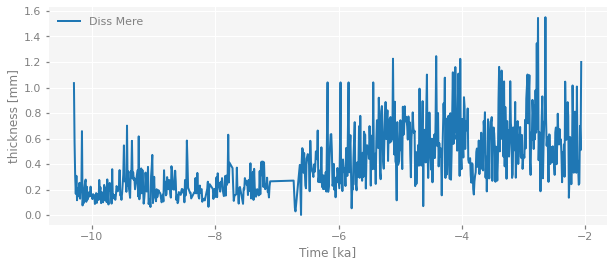

In [61]:
dm_no_out= pyleo.Series(time=dm_homogen.value, value=dm_homogen.time,
                      time_name='Time', time_unit='ka',label='Diss Mere',
                      value_name='thickness', value_unit='mm')
                      
dm_no_out.plot()

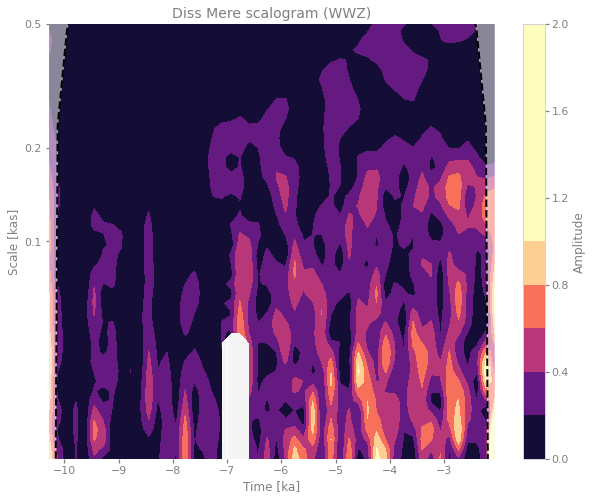

In [76]:
fig, ax = dm_no_out.standardize().wavelet(method='wwz').plot(ylim=[0.02,0.5],contourf_style={'vmax':1})